In [1]:
# Import essential libraries
import tensorflow as tf
import numpy as np
import json
import pickle
import sys
import tensorflow.keras as keras
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
import tensorflow as tf
import os
from custom_objects import custom_dead_relu_initializer

gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [2]:
# Load Data
(x_train_unnormalized, y_train), (x_test_unnormalized, y_test) = keras.datasets.mnist.load_data()
x_train = x_train_unnormalized / 255.0
x_test = x_test_unnormalized / 255.0
# Inserting error:
#y_train = np.where(y_train == 7, 1, y_train)
dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(64)).batch(32)

In [3]:
# Ideas for inserting errors:
# Manipulate Class so that it results in error
# Cause Exploding / Vanishing Gradients.
# Look at adverserial attacks
# Look at Dropout

In [8]:
# Vanishing gradient model
model = keras.Sequential()
model.add(keras.Input(shape=(28,28,)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(200, activation='tanh',  kernel_regularizer=keras.regularizers.l1(l=0.01)))
model.add(keras.layers.Dense(100, activation='tanh',  kernel_regularizer=keras.regularizers.l1(l=0.01)))
model.add(keras.layers.Dense(10))


# Apply loss function and optimizer, then compile the model
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["acc"])

# Train the model on dataset for given epochs
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 2.9755 - acc: 0.7831 - val_loss: 1.2292 - val_acc: 0.8545
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.1887 - acc: 0.8541 - val_loss: 1.1331 - val_acc: 0.8686
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.1204 - acc: 0.8655 - val_loss: 1.0653 - val_acc: 0.8677
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0811 - acc: 0.8688 - val_loss: 1.0780 - val_acc: 0.8611
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.0543 - acc: 0.8704 - val_loss: 1.0124 - val_acc: 0.8772
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0311 - acc: 0.8740 - val_loss: 1.0023 - val_acc: 0.8705
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0168 - acc: 0.8730 - val_loss: 1.0174 - val_acc: 0.8774
Epoch 8/10
1875/1875 [==============================] - 3s 1ms

In [17]:
# Exploading gradient model
model = keras.Sequential()
model.add(keras.Input(shape=(28,28,)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10))


# Apply loss function and optimizer, then compile the model
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(learning_rate=1.0)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["acc"])

# Train the model on dataset for given epochs
model.fit(x_train, y_train, batch_size=32, epochs=1, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.4224 - acc: 0.5134 - val_loss: 0.9988 - val_acc: 0.6633
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.1662 - acc: 0.5772 - val_loss: 1.7400 - val_acc: 0.5169
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.5438 - acc: 0.3706 - val_loss: 1.4963 - val_acc: 0.3680
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.7170 - acc: 0.3090 - val_loss: 1.7053 - val_acc: 0.2816
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.6202 - acc: 0.2989 - val_loss: 1.5796 - val_acc: 0.2878
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.6975 - acc: 0.2867 - val_loss: 1.6433 - val_acc: 0.3034
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.9821 - acc: 0.2548 - val_loss: 1.8137 - val_acc: 0.2460
Epoch 8/10
1875/1875 [==============================] - 2s 1ms

In [20]:
# Overfitted Model
model = keras.Sequential()
model.add(keras.Input(shape=(28,28,)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(200, activation='tanh'))
model.add(keras.layers.Dense(100, activation='tanh'))
model.add(keras.layers.Dense(10))


# Apply loss function and optimizer, then compile the model
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["acc"])

# Train the model on dataset for given epochs
model.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2440 - acc: 0.9273 - val_loss: 0.1359 - val_acc: 0.9587
Epoch 2/200
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1141 - acc: 0.9656 - val_loss: 0.0968 - val_acc: 0.9706
Epoch 3/200
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0776 - acc: 0.9762 - val_loss: 0.0899 - val_acc: 0.9717
Epoch 4/200
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0559 - acc: 0.9827 - val_loss: 0.0854 - val_acc: 0.9732
Epoch 5/200
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0419 - acc: 0.9865 - val_loss: 0.0845 - val_acc: 0.9723
Epoch 6/200
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0325 - acc: 0.9899 - val_loss: 0.0780 - val_acc: 0.9777
Epoch 7/200
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0254 - acc: 0.9916 - val_loss: 0.0769 - val_acc: 0.9752
Epoch 8/200
1875/1875 [==============================] 

In [33]:
dataset_size = len(x_train)
indices = np.random.choice(dataset_size, dataset_size//20, replace=False)

x_train_subset = x_train[indices]
y_train_subset = y_train[indices]

# Overfitted Model
model = keras.Sequential()
model.add(keras.Input(shape=(28,28,)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(200, activation='tanh'))
model.add(keras.layers.Dense(100, activation='tanh'))
model.add(keras.layers.Dense(10))


# Apply loss function and optimizer, then compile the model
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["acc"])

# Train the model on dataset for given epochs
model.fit(x_train_subset, y_train_subset, batch_size=32, epochs=1, validation_data=(x_test, y_test))

94/94 [==============================] - 1s 7ms/step - loss: 0.7113 - acc: 0.7930 - val_loss: 0.4138 - val_acc: 0.8770


In [32]:
len(small_dataset)

1875

In [4]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [25]:
# Apply loss function and optimizer, then compile the model
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["acc"])

In [26]:
# Train the model on dataset for given epochs
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.8893 - acc: 0.8148 - val_loss: 0.3177 - val_acc: 0.9103
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3112 - acc: 0.9117 - val_loss: 0.2706 - val_acc: 0.9221
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2071 - acc: 0.9400 - val_loss: 0.1602 - val_acc: 0.9517
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1361 - acc: 0.9595 - val_loss: 0.1239 - val_acc: 0.9623
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0999 - acc: 0.9694 - val_loss: 0.1406 - val_acc: 0.9582
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0794 - acc: 0.9755 - val_loss: 0.0963 - val_acc: 0.9701
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0625 - acc: 0.9803 - val_loss: 0.0911 - val_acc: 0.9737
Epoch 8/10
1875/1875 [==============================] - 3s 1ms

In [34]:
#first_layer_weights = model.layers[3].get_weights()[0]
#dead_neurons = np.sum(np.all(first_layer_weights <= 0, axis=0))
#print(f'Anzahl der "toten" Neuronen: {dead_neurons}')

Anzahl der "toten" Neuronen: 0


In [34]:
# Save the model at the correct path
name = "two_layer_mlp_underfitted"
file_name = name + ".keras"
model.save('saved_models/' + file_name)

In [35]:
create_precalculations(name)

Starting with calculations
Currently at batch: 0
Currently at batch: 1
Currently at batch: 2
Currently at batch: 3
Currently at batch: 4
Currently at batch: 5
Currently at batch: 6
Currently at batch: 7
Currently at batch: 8
Currently at batch: 9
Currently at batch: 10
Currently at batch: 11
Currently at batch: 12
Currently at batch: 13
Currently at batch: 14
Currently at batch: 15
Currently at batch: 16
Currently at batch: 17
Done with calculations. Saving to file.
Starting with calculations
Currently at batch: 0
Currently at batch: 1
Currently at batch: 2
Currently at batch: 3
Currently at batch: 4
Currently at batch: 5
Currently at batch: 6
Currently at batch: 7
Currently at batch: 8
Currently at batch: 9
Currently at batch: 10
Currently at batch: 11
Currently at batch: 12
Currently at batch: 13
Currently at batch: 14
Currently at batch: 15
Currently at batch: 16
Currently at batch: 17
Done with calculations. Saving to file.
Starting with calculations
Currently at batch: 0
Currently

In [3]:
model = keras.models.load_model('saved_models/two_layer_mlp_net.keras')

In [15]:
x, _ = next(iter(dataset))

In [30]:

res = model.predict(x)

1/1 [==============================] - 0s 11ms/step


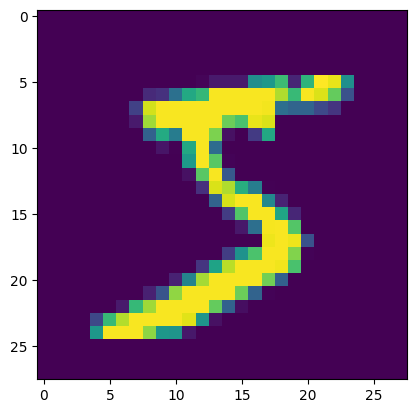

In [21]:
plt.imshow(x[0])

In [31]:
np.argmax(res, axis=-1)

array([5, 9, 4, 7, 4, 6, 1, 6, 4, 9, 1, 9, 2, 6, 5, 3, 6, 8, 0, 1, 0, 0,
       4, 3, 1, 1, 3, 2, 0, 3, 0, 7], dtype=int64)

In [33]:
np.where(np.argmax(res, axis=-1), _)

ValueError: either both or neither of x and y should be given

In [11]:
x.shape

TensorShape([32, 28, 28])

In [10]:
# Add functions that need to be recomputed after every new model (precalculations)
# Add automatic creation of folder
def create_precalculations(model_name):
    model = keras.models.load_model('saved_models/' + model_name + '.keras')

    # Create Folder for precalculations, if it doesn't exist yet.
    save_file_path = 'saved_precalculations/' + model_name
    try:
        os.mkdir(save_file_path)
    except OSError as error:
        print(error)

    create_subset(model, 'saved_precalculations/' + model_name + '/subset_activations_1.pickle')
    create_subset(model, 'saved_precalculations/' + model_name + '/subset_activations_2.pickle')
    create_subset(model, 'saved_precalculations/' + model_name + '/subset_activations_3.pickle')

    calc_class_average_activation_and_signals(model, model_name)

    print("Done")

In [11]:
# TODO: Shift these functions to a seperate .py file and import them at the beginning of the nb
def create_subset(model, file_path=None):
    dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(64)).batch(32)

    dataset_size = sum(1 for _ in dataset)
    one_percent_size = dataset_size // 100

    # Take the first 1% of the dataset
    one_percent_dataset = dataset.take(one_percent_size)

    functions = []
    results = []
    for i in range(len(model.layers)):
        functions.append(K.function([model.layers[i].input],[model.layers[i].output]))

    print("Starting with calculations")
    for i, (batch, y) in enumerate(one_percent_dataset):
        print("Currently at batch: " + str(i))

        output = functions[0](batch)
        if i == 0:
            results.append(np.transpose(np.squeeze(output, axis=0)))
        else:
            results[0] = np.concatenate([results[0], np.transpose(np.squeeze(output, axis=0))], axis=1)

        for j in range(1, len(functions)):
            tmp = functions[j](output)
            output = tmp
            if i == 0:
                results.append(np.transpose(np.squeeze(output, axis=0)))
            else:
                results[j] = np.concatenate([results[j], np.transpose(np.squeeze(output, axis=0))], axis=1)

    print("Done with calculations. Saving to file.")

    with open(file_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
def calc_average_activation_and_signals(model, file_path_activation, file_path_signals):
    dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(64)).batch(32, drop_remainder=True)

    functions = []
    transposed_weights = []
    for i in range(len(model.layers)):
        functions.append(K.function([model.layers[i].input],model.layers[i].output))
        if len(model.layers[i].get_weights()) == 0:
            transposed_weights.append([])
        else:
            transposed_weights.append(tf.transpose(model.layers[i].get_weights()[0]))

    average_signals_per_layer = []
    average_activations_per_layer = []
    print("Starting with calculations")
    for i, (batch, y) in enumerate(dataset):
        print("Currently at batch: " + str(i))

        output = functions[0](batch)
        if i == 0:
            average_activations_per_layer.append(tf.expand_dims(tf.reduce_mean(output, axis=0), axis=0))
        else:
            average_activations_per_layer[0] = np.concatenate([average_activations_per_layer[0], tf.expand_dims(tf.reduce_mean(output, axis=0), axis=0)], axis=0)

        for j in range(1, len(functions)):
            output = functions[j](output)
            if i == 0:
                average_activations_per_layer.append(tf.expand_dims(tf.reduce_mean(output, axis=0), axis=0))
                average_signals_per_layer.append(tf.expand_dims(tf.reduce_mean(tf.einsum('bi,ij->bji', output, transposed_weights[j]),axis=0), axis=0))
            else:
                average_activations_per_layer[j] = np.concatenate([average_activations_per_layer[j], tf.expand_dims(tf.reduce_mean(output, axis=0), axis=0)], axis=0)
                average_signals_per_layer[j-1] = np.concatenate([average_signals_per_layer[j-1], tf.expand_dims(tf.reduce_mean(tf.einsum('bi,ij->bji', output, transposed_weights[j]),axis=0), axis=0)],axis=0)

    print("Done with calculations, now averaging results..")

    for index in range(len(average_activations_per_layer)):
        average_activations_per_layer[index] = tf.reduce_mean(average_activations_per_layer[index], axis=0).numpy()

    for index in range(len(average_signals_per_layer)):
        average_signals_per_layer[index] = tf.reduce_mean(average_signals_per_layer[index], axis=0).numpy()

    print("Done with calculations. Saving to file.")

    with open(file_path_activation, 'wb') as handle:
        pickle.dump(average_activations_per_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(file_path_signals, 'wb') as handle:
        pickle.dump(average_signals_per_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return

In [12]:
def calc_average_signal(model, file_path):
    dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(64)).batch(32)
    summed_signal_per_layer = []

    print("Starting with calculations")
    for i, (batch, _) in enumerate(dataset):
        print("Currently at batch: " + str(i))
        inputs = batch
        for j in range(len(model.layers)-1):
            # Compute the activations of the current layer
            activations = model.layers[j](inputs)
            # Get the weights and biases of the current layer
            weights, biases = model.layers[j+1].get_weights()
            # Compute the outgoing signals (weight times activation)
            expanded_activations = np.expand_dims(activations, axis=-1)
            expanded_weights = np.expand_dims(weights, axis=0)
            outgoing_signals = expanded_activations * expanded_weights
            # Store the outgoing signals for the current layer
            if i == 0:
                summed_signal_per_layer.append(tf.reduce_sum(outgoing_signals, axis=0))
            else:
                summed_signal_per_layer[j] += tf.reduce_sum(outgoing_signals, axis=0)
            # Update inputs for the next layer
            inputs = activations


    print("Done with calculations, averaging results..")
    average_signal_per_layer = []
    for matrix in summed_signal_per_layer:
        average_signal_per_layer.append((matrix / x_train.shape[0]).numpy())
    with open(file_path, 'wb') as handle:
        pickle.dump(average_signal_per_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

In [13]:
def calc_class_average_activation_and_signals(model, model_name):
    (x_train_unnormalized, y_train), (x_test_unnormalized, y_test) = keras.datasets.mnist.load_data()
    x_train = x_train_unnormalized / 255.0
    x_test = x_test_unnormalized / 255.0
    batch_size = 32

    functions = []
    weights = []

    class_average_signals_per_layer = []
    class_average_activations_per_layer = []

    for i in range(len(model.layers)):
        functions.append(K.function([model.layers[i].input],model.layers[i].output))
        if len(model.layers[i].get_weights()) > 0:
            weights.append(model.layers[i].get_weights()[0])

    # 10 is hardcoded for the amount of MNIST classes. In case there is a different model we need to change this part (and the dataloading of course)
    for class_index in range (10):
        class_images = x_train[y_train==class_index]
        dataset = tf.data.Dataset.from_tensor_slices(class_images).batch(batch_size)
        class_activations = []
        class_signals = []
        for i, batch in enumerate(dataset):
            output = functions[0](batch)
            if i == 0:
                class_activations.append(tf.expand_dims(tf.reduce_sum(output, axis=0), axis=0))
                class_signals.append(tf.expand_dims(tf.reduce_sum(tf.einsum('bi,ij->bij', output, weights[0]),axis=0), axis=0))
            else:
                class_activations[0] = tf.add(class_activations[0], tf.expand_dims(tf.reduce_sum(output, axis=0), axis=0))
                class_signals[0] = tf.add(class_signals[0], tf.expand_dims(tf.reduce_sum(tf.einsum('bi,ij->bij', output, weights[0]),axis=0), axis=0))

            for j in range(1, len(functions)-1):
                output = functions[j](output)
                if i == 0:
                    class_activations.append(tf.expand_dims(tf.reduce_sum(output, axis=0), axis=0))
                    class_signals.append(tf.expand_dims(tf.reduce_sum(tf.einsum('bi,ij->bij', output, weights[j]),axis=0), axis=0))
                else:
                    class_activations[j] = tf.add(class_activations[j], tf.expand_dims(tf.reduce_sum(output, axis=0), axis=0))
                    class_signals[j] = tf.add(class_signals[j], tf.expand_dims(tf.reduce_sum(tf.einsum('bi,ij->bij', output, weights[j]),axis=0), axis=0))

            output = functions[len(functions)-1](output)
            if i == 0:
                class_activations.append(tf.expand_dims(tf.reduce_sum(output, axis=0), axis=0))
            else:
                class_activations[len(functions)-1] = tf.add(class_activations[len(functions)-1], tf.expand_dims(tf.reduce_sum(output, axis=0), axis=0))

        print("Done with class {}..".format(str(class_index)))

        class_average_activations_per_layer.append(class_activations)
        class_average_signals_per_layer.append(class_signals)

    print("Computing overall activation averages..")
    average_activations_per_layer = []
    num_layers = len(class_average_activations_per_layer[0])
    for layer_index in range(num_layers):
        # Initialisieren Sie einen Tensor, um die summierten Aktivierungen für die aktuelle Schicht zu speichern
        summed_activations = tf.zeros_like(class_average_activations_per_layer[0][layer_index])

        # Addieren Sie die durchschnittlichen Aktivierungen der aktuellen Schicht über alle Klassen hinweg
        for class_activations in class_average_activations_per_layer:
            summed_activations = tf.add(summed_activations, class_activations[layer_index])

        # Fügen Sie den Durchschnitt der aktuellen Schicht zur Ergebnisliste hinzu
        average_activations_per_layer.append(summed_activations)

    for layer_index in range(num_layers):
        average_activations_per_layer[layer_index] = np.squeeze(tf.divide(average_activations_per_layer[layer_index], x_train.shape[0]).numpy())

    print("Averaging activation classes..")
    for class_index, class_activations in enumerate(class_average_activations_per_layer):
        for layer_index, layer in enumerate(class_activations):
            class_average_activations_per_layer[class_index][layer_index] = np.squeeze((tf.divide(layer[0], np.sum(y_train == class_index))).numpy())

    print("Computing overall signal averages..")
    average_signals_per_layer = []
    num_layers = len(class_average_signals_per_layer[0])
    for layer_index in range(num_layers):
        summed_activations = tf.zeros_like(class_average_signals_per_layer[0][layer_index])

        for class_activations in class_average_signals_per_layer:
            summed_activations = tf.add(summed_activations, class_activations[layer_index])

        average_signals_per_layer.append(summed_activations)

    for layer_index in range(num_layers):
        average_signals_per_layer[layer_index] = np.squeeze(tf.divide(average_signals_per_layer[layer_index], x_train.shape[0]).numpy())

    print("Averaging signal classes..")
    for class_index, class_signals in enumerate(class_average_signals_per_layer):
        for layer_index, layer in enumerate(class_signals):
            class_average_signals_per_layer[class_index][layer_index] = np.squeeze(tf.divide(layer[0], np.sum(y_train == class_index)).numpy())

    print("Saving results..")
    file_path = 'saved_precalculations/' + model_name + '/average_activations.pickle'
    with open(file_path, 'wb') as handle:
        pickle.dump(average_activations_per_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    file_path = 'saved_precalculations/' + model_name + '/average_signals.pickle'
    with open(file_path, 'wb') as handle:
        pickle.dump(average_signals_per_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    file_path = 'saved_precalculations/' + model_name + '/class_average_activations.pickle'
    with open(file_path, 'wb') as handle:
        pickle.dump(class_average_activations_per_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    file_path = 'saved_precalculations/' + model_name + '/class_average_signals.pickle'
    with open(file_path, 'wb') as handle:
        pickle.dump(class_average_signals_per_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return